#### IMPORTS

In [485]:
import os
from collections import defaultdict
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from math import log, log10
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score

#### PARAMETER

In [486]:
LEGIT = "LEGIT"
SPAM = "SPAM"
NUMBER_OF_PARTS = 10
ALPHAS = [10 ** i for i in range(-16, -6)]
LAMBDAS = [10 ** i for i in range(0, 301, 20)]
KF = KFold(NUMBER_OF_PARTS)

#### UTIL

In [487]:
def get_class(filename) -> str:
    return LEGIT if "legit" in filename else SPAM


def read_file(filename: str, n: int = 1) -> (str, list, str):
    with open(filename, "r") as file:
        subject = transform_to_n_gram(file.readline().split()[1:], n)
        file.readline()
        body = transform_to_n_gram(file.readline().split(), n)
        return subject, body, get_class(filename=filename)


def read_part(n: int, i: int):
    package_name = "data/part%s" % (i + 1)
    files = []

    for path in ["%s/%s" % (package_name, file_name) for file_name in os.listdir(package_name)]:
        subject, body, c = read_file(path, n)
        files.append((subject, c))
        files.append((body, c))

    return files


def transform_to_n_gram(message, n):
    n_gram = []
    for i in range(len(message) - n + 1):
        n_gram.append(message[i:(i + n)])
    return n_gram


def sentence_to_word(sentence):
    return "!".join(sentence)


#### BAYES

In [488]:
class Bayes(object):
    def __init__(self, train_data):
        self.classes_count = defaultdict(lambda: 0)
        self.frequencies = defaultdict(lambda: 0)
        self.files_count = len(train_data)
        for (message, message_type) in train_data:
            self.classes_count[message_type] += 1

            for sentence in message:
                self.frequencies[message_type, sentence_to_word(sentence)] += 1
        for message_type, sentence in self.frequencies:
            self.frequencies[message_type, sentence] /= self.classes_count[message_type]

    def predict(self, message_body: [int], lambda_legit, lambda_spam, alpha):
        p_legit = self.get_probability(LEGIT, message_body, alpha, lambda_legit)
        p_spam = self.get_probability(SPAM, message_body, alpha, lambda_spam)
        return LEGIT if p_legit > p_spam else SPAM, p_legit, p_spam

    def get_probability(self, message_type: str, message_body: [int], alpha: float, lmb: float):
        p = log(lmb * self.classes_count[message_type] / self.files_count)
        return p + sum([log((self.frequencies[message_type, sentence_to_word(sentence)] + alpha) /
                            (self.classes_count[message_type] + 2 * alpha))
                        for sentence in message_body])


#### BEST PARAMS

In [489]:
def get_k_fold_data(data, train_index, test_index):
    def get_data(index):
        return data[index].reshape(-1, data[index].shape[-1])

    return get_data(train_index), get_data(test_index)


def find_best_alpha(data):
    best_alpha = -1
    best_accuracy = 0
    print("Searching alpha...")
    for alpha in ALPHAS:
        accuracy = 0
        for (train_index, test_index) in KF.split(data):
            train_data, test_data = get_k_fold_data(data, train_index, test_index)
            model = Bayes(train_data)
            actual = [message_type for (message_body, message_type) in test_data]
            predictions = [model.predict(message_body=message_body,
                                         lambda_legit=1e-5,
                                         lambda_spam=1e-5,
                                         alpha=alpha)[0] for (message_body, message_type) in test_data]
            accuracy += accuracy_score(predictions, actual) / NUMBER_OF_PARTS
        print("Alpha = {}, accuracy = {}".format(alpha, accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
    return best_alpha, best_accuracy


def find_best_lambda(data, alpha):
    best_lambda = 1
    lambda_degrees = []
    accuracy_scores = []
    print("Searching lambda...")
    for lambda_legit in LAMBDAS:
        accuracy = 0
        fn_count = 0
        all_predictions = []
        all_actual = []
        for (train_index, test_index) in KF.split(data):
            train_data, test_data = get_k_fold_data(data, train_index, test_index)
            model = Bayes(train_data)
            actual = [message_type for (message_body, message_type) in test_data]
            predictions = [model.predict(message_body=message_body,
                                         lambda_legit=lambda_legit,
                                         lambda_spam=1e-5,
                                         alpha=alpha)[0] for (message_body, message_type) in test_data]
            accuracy += accuracy_score(predictions, actual) / NUMBER_OF_PARTS
            all_predictions.extend(predictions)
            all_actual.extend(actual)

        for x, y in zip(all_predictions, all_actual):
            if x == SPAM and y == LEGIT:
                fn_count += 1

        if fn_count == 0:
            best_lambda = lambda_legit

        degree = int(log10(lambda_legit))
        lambda_degrees.append(degree)
        accuracy_scores.append(accuracy)

        print("FN count = {}, Lambda 1e{}, accuracy:= {}".format(fn_count, degree, accuracy))

    return best_lambda, lambda_degrees, accuracy_scores


#### PLOTS

In [490]:
def draw(xs, ys, label, x_label, y_label):
    plt.plot(xs, ys, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_roc_curve(data, best_alpha, best_lambda):
    mapper = {LEGIT: 1, SPAM: 0}
    model = Bayes(data)
    roc_data = np.array([(mapper[message_type],
                          mapper[model.predict(message_body=message_body,
                                               lambda_legit=best_lambda,
                                               lambda_spam=1,
                                               alpha=best_alpha)[0]]
                          ) for (message_body, message_type) in data])

    x, y = roc_data[:, 0], roc_data[:, 1]
    roc_xs, roc_ys, _ = roc_curve(x, y)
    draw(xs=roc_xs, ys=roc_ys, label='ROC curve = {}'.format(roc_auc_score(x, y)), x_label='FP rate', y_label='TP rate')


#### MAIN

Searching alpha...
Alpha = 1e-16, accuracy = 0.939908256880734
Alpha = 1e-15, accuracy = 0.9399082568807341
Alpha = 1e-14, accuracy = 0.9399082568807341
Alpha = 1e-13, accuracy = 0.9385321100917432
Alpha = 1e-12, accuracy = 0.9385321100917432
Alpha = 1e-11, accuracy = 0.9348623853211009
Alpha = 1e-10, accuracy = 0.9325688073394496
Alpha = 1e-09, accuracy = 0.9311926605504588
Alpha = 1e-08, accuracy = 0.9247706422018348
Alpha = 1e-07, accuracy = 0.9206422018348623
Best alpha = 1e-15, accuracy = 0.9399082568807341, n = 1
Searching lambda...
FN count = 24, Lambda 1e0, accuracy:= 0.8830275229357798
FN count = 13, Lambda 1e20, accuracy:= 0.7788990825688074
FN count = 10, Lambda 1e40, accuracy:= 0.7559633027522936
FN count = 7, Lambda 1e60, accuracy:= 0.7509174311926606
FN count = 5, Lambda 1e80, accuracy:= 0.7412844036697248
FN count = 4, Lambda 1e100, accuracy:= 0.7330275229357799
FN count = 3, Lambda 1e120, accuracy:= 0.7243119266055047
FN count = 3, Lambda 1e140, accuracy:= 0.71605504587

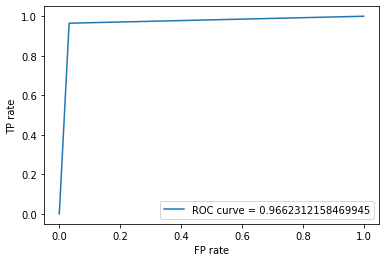

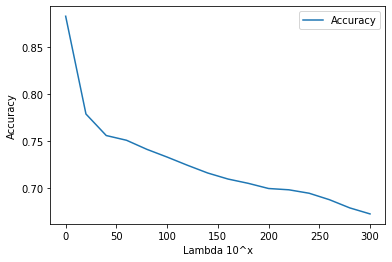

Searching alpha...
Alpha = 1e-16, accuracy = 0.9334862385321101
Alpha = 1e-15, accuracy = 0.9334862385321101
Alpha = 1e-14, accuracy = 0.9334862385321101
Alpha = 1e-13, accuracy = 0.9334862385321101
Alpha = 1e-12, accuracy = 0.9334862385321101
Alpha = 1e-11, accuracy = 0.9330275229357798
Alpha = 1e-10, accuracy = 0.9325688073394496
Alpha = 1e-09, accuracy = 0.9307339449541285
Alpha = 1e-08, accuracy = 0.9311926605504588
Alpha = 1e-07, accuracy = 0.9293577981651375
Best alpha = 1e-16, accuracy = 0.9334862385321101, n = 2
Searching lambda...
FN count = 24, Lambda 1e0, accuracy:= 0.9050458715596331
FN count = 13, Lambda 1e20, accuracy:= 0.8555045871559634
FN count = 8, Lambda 1e40, accuracy:= 0.8018348623853212
FN count = 8, Lambda 1e60, accuracy:= 0.7844036697247706
FN count = 7, Lambda 1e80, accuracy:= 0.7711009174311926
FN count = 5, Lambda 1e100, accuracy:= 0.7669724770642202
FN count = 4, Lambda 1e120, accuracy:= 0.7642201834862385
FN count = 4, Lambda 1e140, accuracy:= 0.76055045871

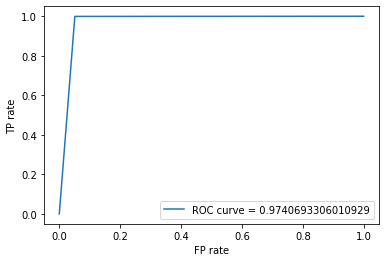

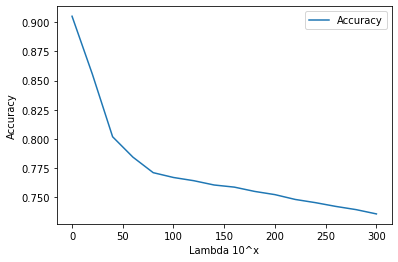

Searching alpha...
Alpha = 1e-16, accuracy = 0.8862385321100917
Alpha = 1e-15, accuracy = 0.8853211009174311
Alpha = 1e-14, accuracy = 0.8848623853211008
Alpha = 1e-13, accuracy = 0.8848623853211008
Alpha = 1e-12, accuracy = 0.8844036697247706
Alpha = 1e-11, accuracy = 0.8876146788990824
Alpha = 1e-10, accuracy = 0.8876146788990824
Alpha = 1e-09, accuracy = 0.8853211009174311
Alpha = 1e-08, accuracy = 0.8834862385321101
Alpha = 1e-07, accuracy = 0.8825688073394495
Best alpha = 1e-11, accuracy = 0.8876146788990824, n = 3
Searching lambda...
FN count = 26, Lambda 1e0, accuracy:= 0.8688073394495414
FN count = 13, Lambda 1e20, accuracy:= 0.8068807339449542
FN count = 12, Lambda 1e40, accuracy:= 0.7766055045871559
FN count = 10, Lambda 1e60, accuracy:= 0.7633027522935779
FN count = 8, Lambda 1e80, accuracy:= 0.7596330275229357
FN count = 6, Lambda 1e100, accuracy:= 0.7518348623853212
FN count = 6, Lambda 1e120, accuracy:= 0.748165137614679
FN count = 6, Lambda 1e140, accuracy:= 0.7435779816

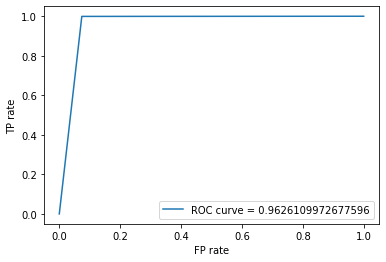

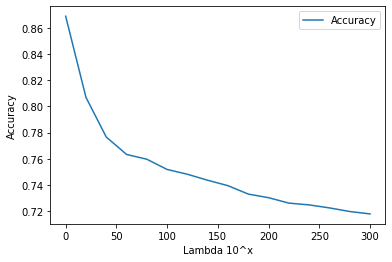

In [491]:
def main():
    for n in range(1, 4):
        parts = np.array([read_part(n, i) for i in range(NUMBER_OF_PARTS)], dtype=object)

        best_alpha, best_accuracy = find_best_alpha(parts)
        print("Best alpha = {}, accuracy = {}, n = {}".format(best_alpha, best_accuracy, n))

        best_lambda, lambda_xs, accuracy_ys = find_best_lambda(parts, alpha=best_alpha)
        print("Best lambda 1e{}".format(int(log10(best_lambda))))

        plot_roc_curve(parts.reshape(-1, parts.shape[-1]), best_alpha=best_alpha, best_lambda=best_lambda)
        draw(xs=lambda_xs, ys=accuracy_ys, label='Accuracy', x_label='Lambda 10^x', y_label='Accuracy')


if __name__ == '__main__':
    main()